# RNA-seq analysis with DESeq2
## Largely from Stephen Turner, @genetics_blog


Using data from GSE37704, with processed data available on Figshare DOI: 10.6084/m9.figshare.1601975.
This dataset has six samples from GSE37704, where expression was quantified by either:
* Mapping to to GRCh38 using STAR then counting reads mapped to genes with featureCounts under the union-intersection model, or
* Alignment-free quantification using Sailfish, summarized at the gene level using the GRCh38 GTFile. Both datasets are restricted to protein-coding genes only.

We're using the Sailfish data.

This example comes from [a gist template for DESeq analyis](https://gist.github.com/stephenturner/f60c1934405c127f09a6) and a [blog post](
http://www.gettinggeneticsdone.com/2015/12/tutorial-rna-seq-differential.html), both by Stephen Turner.

First we pull in the data from a remote copy:

In [1]:
countdata <- read.csv("http://www.dursi.ca/content/images/GSE37704_featurecounts.csv", header=TRUE, row.names=1)
coldata <- read.csv("http://www.dursi.ca/content/images/GSE37704_metadata.csv", header=TRUE, row.names=1)

# Remove first column (length)
countdata <- countdata[-1]

# Convert to matrix
countdata <- as.matrix(countdata)
head(countdata)

,SRR493366,SRR493367,SRR493368,SRR493369,SRR493370,SRR493371
ENSG00000186092,0,0,0,0,0,0
ENSG00000279928,0,0,0,0,0,0
ENSG00000279457,23,28,29,29,28,46
ENSG00000278566,0,0,0,0,0,0
ENSG00000273547,0,0,0,0,0,0
ENSG00000187634,124,123,205,207,212,258


And we start the bioconductor DESeq2 analysis worfklow, first by initializing the DESeqDataSeet from the matrix we've created above:

In [2]:
suppressPackageStartupMessages(library(DESeq2))
dds <- DESeqDataSetFromMatrix(countData=countdata, colData=coldata, design=~condition)
dds

class: DESeqDataSet 
dim: 19808 6 
metadata(0):
assays(1): counts
rownames(19808): ENSG00000186092 ENSG00000279928 ... ENSG00000277475
  ENSG00000268674
rowRanges metadata column names(0):
colnames(6): SRR493366 SRR493367 ... SRR493370 SRR493371
colData names(1): condition

And now running the DESeq Pipeline:

In [3]:
dds <- DESeq(dds)

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


## Quality Control Plots

We next perform some basic QC plots to examine the data behvaiour, first by looking at dispersions to ensure they behave smoothly and broadly decrease with counts:

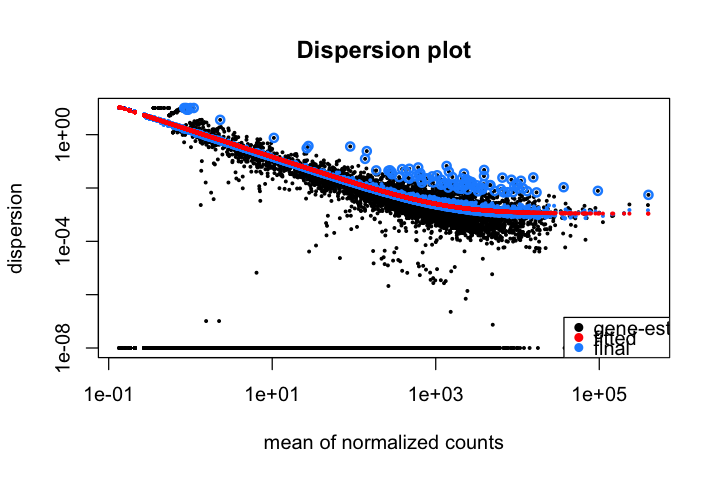

In [4]:
options(repr.plot.height=4, repr.plot.width=6)
plotDispEsts(dds, main="Dispersion plot")

In general we're most interested in logs of the counts; DESeq has a regularlized log transform built in:

In [5]:
# Regularized log transformation for clustering/heatmaps, etc
rld <- rlogTransformation(dds)
head(assay(rld))

,SRR493366,SRR493367,SRR493368,SRR493369,SRR493370,SRR493371
ENSG00000186092,0,0,0,0,0,0
ENSG00000279928,0,0,0,0,0,0
ENSG00000279457,4.880695,4.910085,4.822315,4.913865,4.845717,5.012484
ENSG00000278566,0,0,0,0,0,0
ENSG00000273547,0,0,0,0,0,0
ENSG00000187634,7.390402,7.294805,7.490144,7.648435,7.579775,7.613326


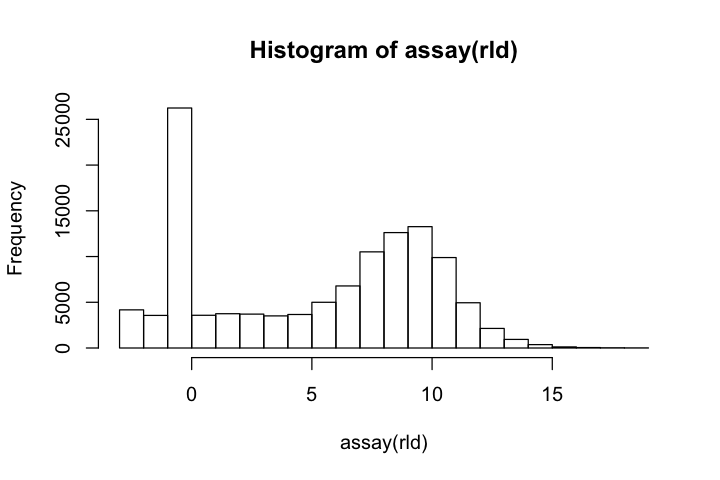

In [6]:
hist(assay(rld))

Now we'll make sure sure the samples cluster together by condition, first by clustering and heatmaps:

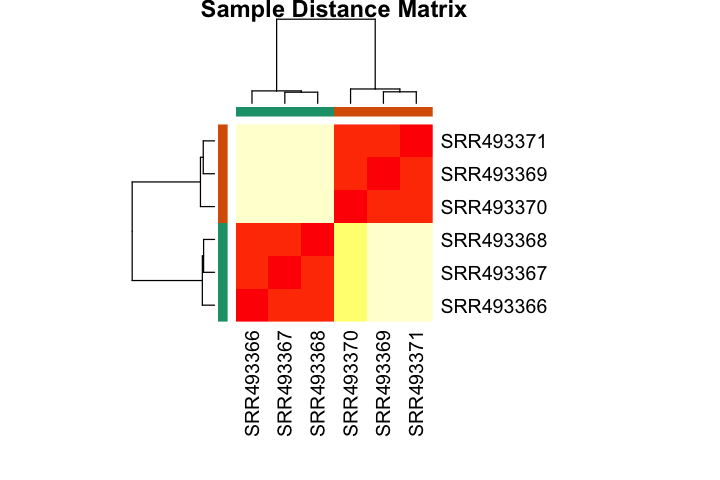

In [7]:
library(RColorBrewer)
mycols <- brewer.pal(8, "Dark2")[1:length(unique(coldata$condition))]

# Sample distance heatmap
sampleDists <- as.matrix(dist(t(assay(rld))))
heatmap(as.matrix(sampleDists),
          ColSideColors=mycols[coldata$condition], RowSideColors=mycols[coldata$condition],
          margin=c(10, 10), main="Sample Distance Matrix")

And next by PCA, using two slightly different visualizations, one supplied by DESeq and one by Stephen Turner:

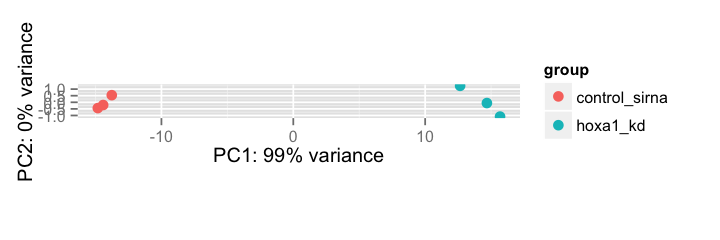

In [8]:
options(repr.plot.height=2, repr.plot.width=6)
DESeq2::plotPCA(rld, intgroup="condition")

Loading required package: genefilter

Attaching package: 'genefilter'

The following object is masked from 'package:base':

    anyNA



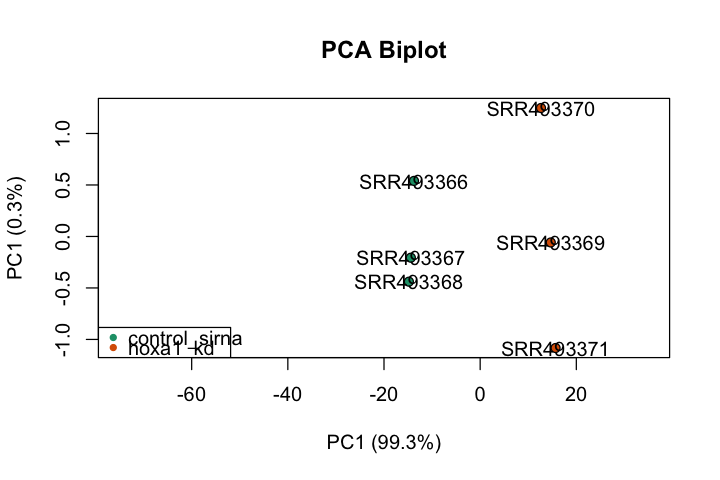

In [9]:
# Nicer PCA plot from Stephen Turner:
st_rld_pca <- function (rld, intgroup = "condition", ntop = 500, colors=NULL, legendpos="bottomleft", main="PCA Biplot", textcx=1, ...) {
  require(genefilter)
  require(RColorBrewer)
  rv = rowVars(assay(rld))
  select = order(rv, decreasing = TRUE)[seq_len(min(ntop, length(rv)))]
  pca = prcomp(t(assay(rld)[select, ]))
  fac = factor(apply(as.data.frame(colData(rld)[, intgroup, drop = FALSE]), 1, paste, collapse = " : "))
  if (is.null(colors)) {
    if (nlevels(fac) >= 3) {
      colors = brewer.pal(nlevels(fac), "Paired")
    }   else {
      colors = c("black", "red")
    }
  }
  pc1var <- round(summary(pca)$importance[2,1]*100, digits=1)
  pc2var <- round(summary(pca)$importance[2,2]*100, digits=1)
  pc1lab <- paste0("PC1 (",as.character(pc1var),"%)")
  pc2lab <- paste0("PC1 (",as.character(pc2var),"%)")
  plot(PC2~PC1, data=as.data.frame(pca$x), bg=colors[fac], pch=21, xlab=pc1lab, ylab=pc2lab, main=main, ...)
  with(as.data.frame(pca$x), text(PC1, PC2, labels=rownames(as.data.frame(pca$x)), cex=textcx))
  legend(legendpos, legend=levels(fac), col=colors, pch=20)
}
options(repr.plot.height=4, repr.plot.width=6)
st_rld_pca(rld, colors=mycols, intgroup="condition", xlim=c(-75, 35))

The case/control samples seem very clearly distinguished in the first principal component.  

## Differential Expression Analysis

Now we perform the differential expression analysis using DESeq2's built in methods, and then order the results by adjusted p-value:

In [10]:
# Get differential expression results
res <- results(dds)
## Order by adjusted p-value
res <- res[order(res$padj), ]
res <- res[complete.cases(res),]
res$pvalue <- ifelse(res$pvalue < 1.e-250, 1.e-250, res$pvalue)

summary(res)


out of 14754 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)     : 4372, 30% 
LFC < 0 (down)   : 4427, 30% 
outliers [1]     : 0, 0% 
low counts [2]   : 0, 0% 
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [11]:
resdata <- merge(as.data.frame(res), as.data.frame(counts(dds, normalized=TRUE)), by="row.names", sort=FALSE)
names(resdata)[1] <- "Gene"
resdata$Gene <- as.character(resdata$Gene)
head(resdata)

,Gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,SRR493366,SRR493367,SRR493368,SRR493369,SRR493370,SRR493371
1,ENSG00000117519,4483.627,-2.415926,0.05998564,-40.27507,1e-250,0,7354.824,7590.284,7725.866,1340.356,1589.833,1300.6
2,ENSG00000183508,2053.881,3.189007,0.07195617,44.31874,1e-250,0,449.2258,410.1969,356.5115,3862.44,3471.057,3773.857
3,ENSG00000159176,5692.463,-2.30776,0.05759359,-40.06973,1e-250,0,9084.343,9652.207,9697.114,1805.595,2125.156,1790.362
4,ENSG00000150938,7442.986,-2.054962,0.05394489,-38.09373,1e-250,0,11798.42,11877.12,12339.65,2780.786,3176.819,2685.135
5,ENSG00000116016,4423.947,-1.885271,0.04324514,-43.59497,1e-250,0,7056.588,6936.157,6903.281,1908.863,1895.461,1843.331
6,ENSG00000164251,2348.77,3.332169,0.06875118,48.46708,1e-250,0,426.7645,427.6987,410.423,4360.682,3936.142,4530.911


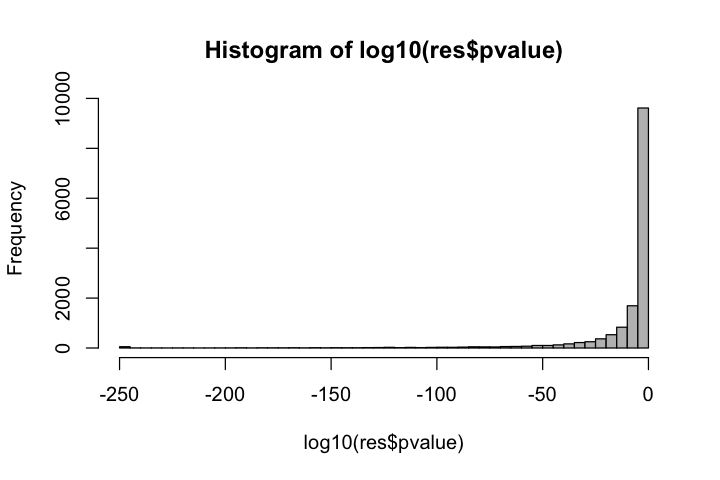

In [12]:
hist(log10(res$pvalue), breaks=50, col="grey")

As we can see, there's a substantial number of genes with extremely small p-values.

### MA plots

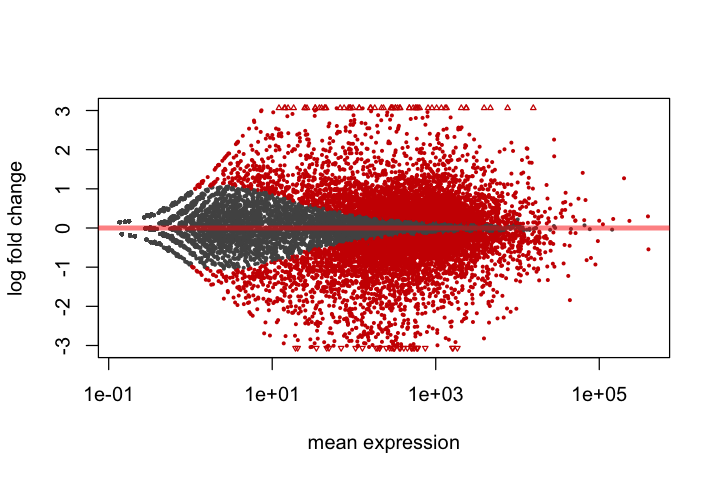

In [13]:
DESeq2::plotMA(dds)

In [14]:
# "Nicer" MA plot from Stephen Turner:
st_maplot <- function (res, thresh=0.05, labelsig=TRUE, topsig=10, textcx=1, ...) {
  with(res, plot(baseMean, log2FoldChange, pch=20, cex=.5, log="x", ...))
  with(subset(res, padj<thresh), points(baseMean, log2FoldChange, col="red", pch=20, cex=1.5))
  if (labelsig) {
    with(res[1:topsig,], text(baseMean, log2FoldChange, labels=Gene, cex=textcx, col="blue"))
    with(res[1:topsig,], points(baseMean, log2FoldChange, col="blue", pch=20, cex=1.75))
  }
}

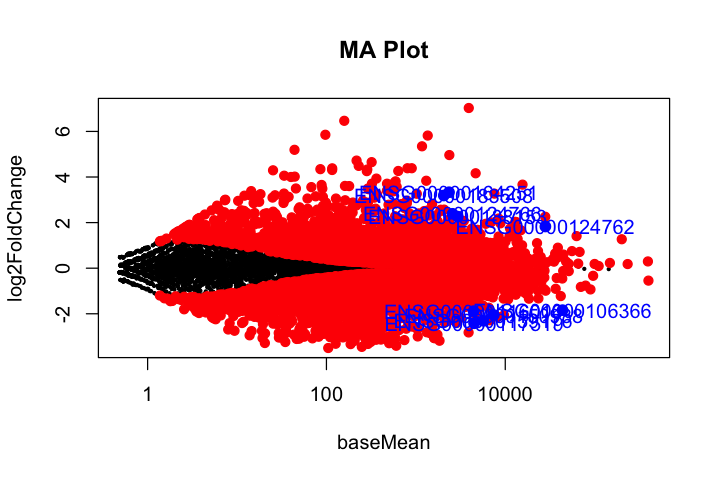

In [15]:
st_maplot(resdata, main="MA Plot")

## Volcano Plot

In [16]:
## Volcano plot with "significant" genes labeled
volcanoplot <- function (res, lfcthresh=2, sigthresh=0.0005, topsig=10, main="Volcano Plot", legendpos="bottomright", labelsig=TRUE, textcx=1, ...) {
  with(res, plot(log2FoldChange, -log10(pvalue), pch=20, main=main, ...))
  with(subset(res, padj<sigthresh ), points(log2FoldChange, -log10(pvalue), pch=20, col="red", ...))
  with(subset(res, abs(log2FoldChange)>lfcthresh), points(log2FoldChange, -log10(pvalue), pch=20, col="orange", ...))
  with(subset(res, padj<sigthresh & abs(log2FoldChange)>lfcthresh), points(log2FoldChange, -log10(pvalue), pch=20, col="green", ...))
  if (labelsig) {
    with(subset(res, -log10(pvalue) != Inf), text(log2FoldChange[1:topsig], -log10(pvalue[1:topsig]), labels=Gene, cex=textcx, col="blue"))
    with(subset(res, -log10(pvalue) != Inf), points(log2FoldChange[1:topsig], -log10(pvalue[1:topsig]), col="blue", pch=20, ...))
  }
  legend(legendpos, xjust=1, yjust=1, legend=c(paste("FDR<",sigthresh,sep=""), paste("|LogFC|>",lfcthresh,sep=""), "both", "most significant"), pch=20, col=c("red","orange","green","blue"))
}

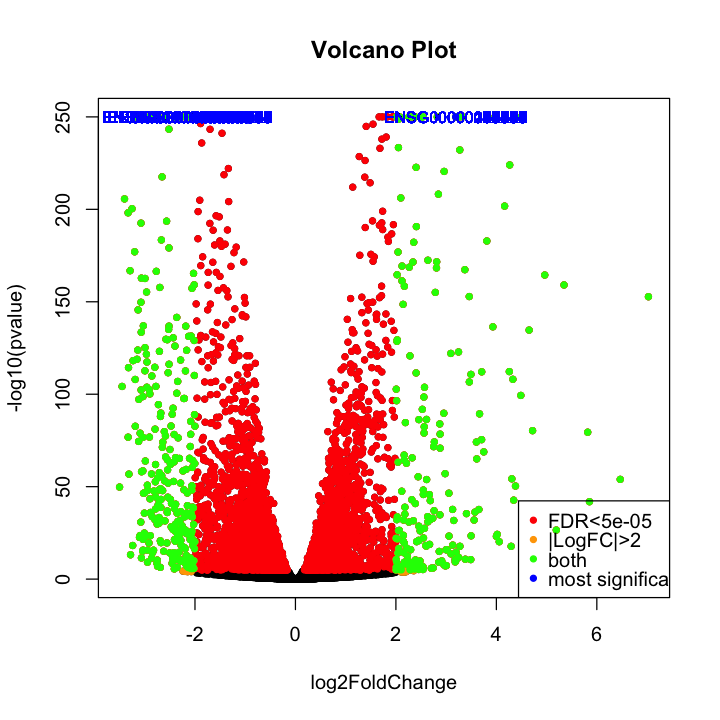

In [17]:
options(repr.plot.height=6, repr.plot.width=6)
volcanoplot(resdata, lfcthresh=2, sigthresh=0.00005, textcx=.8, topsig=5)